# swissQuant Task

"Your task is to complete the following challenge:
- Loan Default Prediction – Imperial College London https://www.kaggle.com/c/loan-default-prediction
- Submit your solution to Kaggle for evaluation (send a screenshot of your submission)
- Share your solution in a public github repository

Specifically,
- Develop an algorithm using Python to predict loan defaults and the amount of the default
    - Code a data loading, pre-processing and preliminary analysis script. Explain how you efficiently deal with the
    large number of training instances, how you handle the high dimensionality of the problem as well as any observed
    data problems (e.o. missing data).
    - Explain if and how you will use the unlabeled data set.
    - Explain which machine learning algorithm is in your opinion theoretically best suited
    for the given task.
    - Implement the machine learning algorithm, that you think is most appropriate (using public available Pythonpackages and a tailor made script). Train and validate the model and explain the chosen procedure and your results.
    - Discuss pro and cons of the developed approach and suggest improvement directions
- Rules
    - We expect that you come up with a solution by our own. We want to see your approach to the problem.
    - You may use Kaggle’s discussion forum for inspiration, however you may not use a posted solution as your own. Don’t use the “Golden Features” proposed in the forum (it is easy to spot if you do).
    - Prepare your script and discussions in a professional manner."

# 0. Imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import f_regression
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LassoCV, Ridge, RidgeCV, LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from numpy import loadtxt
from sklearn.metrics import accuracy_score

%matplotlib inline

# 1. Exploratory Data Analysis:
Data loading, pre-processing and preliminary analysis
## 1A. Data imports and first look at the data, incl. size check:
1. Get the size of all data sets. According to the warnings below, the training data has mixed types in columns 135, 204, 274, 417, while the test data has them only in column 417.
2. The dtypes (object, int, float, category) add up to 19 + 99 + 653 + 0 = 771, implying that there are no explicit categorical values in any of the columns, however columns with int values could still be categorical (e.g. 0 = male, 1 = female)
3. Confirm that the headers are non-descript, except 'id' and 'loss' (the latter being the target variable, which is not present in the test data)
4. Remove any NAs in the data: as part of the data cleaning, all rows containing values with 'NA' are removed.

In [2]:
# 1. Import data & check size/dimensions:
data = pd.read_csv('train_v2.csv')
data_test = pd.read_csv('test_v2.csv')
sampleSubmission = pd.read_csv('sampleSubmission.csv')
print("shape of data:", data.shape)
print("shape of data_test:", data_test.shape)
print("shape of sampleSubmission:", sampleSubmission.shape)

# 2. Check dtypes:
print('number of object dtypes:', len(data.select_dtypes(include=['object']).dtypes))
print('number of int dtypes:', len(data.select_dtypes(include=['int']).dtypes))
print('number of float dtypes:', len(data.select_dtypes(include=['float']).dtypes))
print('number of category dtypes:', len(data.select_dtypes(include=['category']).dtypes))

# 3. Check header names:
data_header_names = data.columns.get_values()
#print(data_header_names)

# 4. Remove NAs:
print('Shape of "data" DataFrame BEFORE dropping NA:', data.shape)
data = data.dropna(axis=0, how='any')
print('Shape of "data" DataFrame AFTER dropping NA:', data.shape)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (135,204,274,417) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (417) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


shape of data: (105471, 771)
shape of data_test: (210944, 770)
shape of sampleSubmission: (210944, 2)
number of object dtypes: 19
number of int dtypes: 99
number of float dtypes: 653
number of category dtypes: 0
Shape of "data" DataFrame BEFORE dropping NA: (105471, 771)
Shape of "data" DataFrame AFTER dropping NA: (51940, 771)


## 1B. A closer look at the target variable "loss":
- The 1st histogram below shows that the majority of losses have a value of 0 (i.e. 0%, no default), and only very few loans default partially or completely ("100" = 100%, a complete loss).
- The 2nd histogram has all the undefaulted loans (loss = 0) removed, to get a better picture of the distribution of the non-zero loss values.

Furthermore, there are about 5'275 loans that defaulted to some degree (1% - 100%), which amounts to ca. 10% of the total loans of 51'940 in the (cleaned-up) training data.

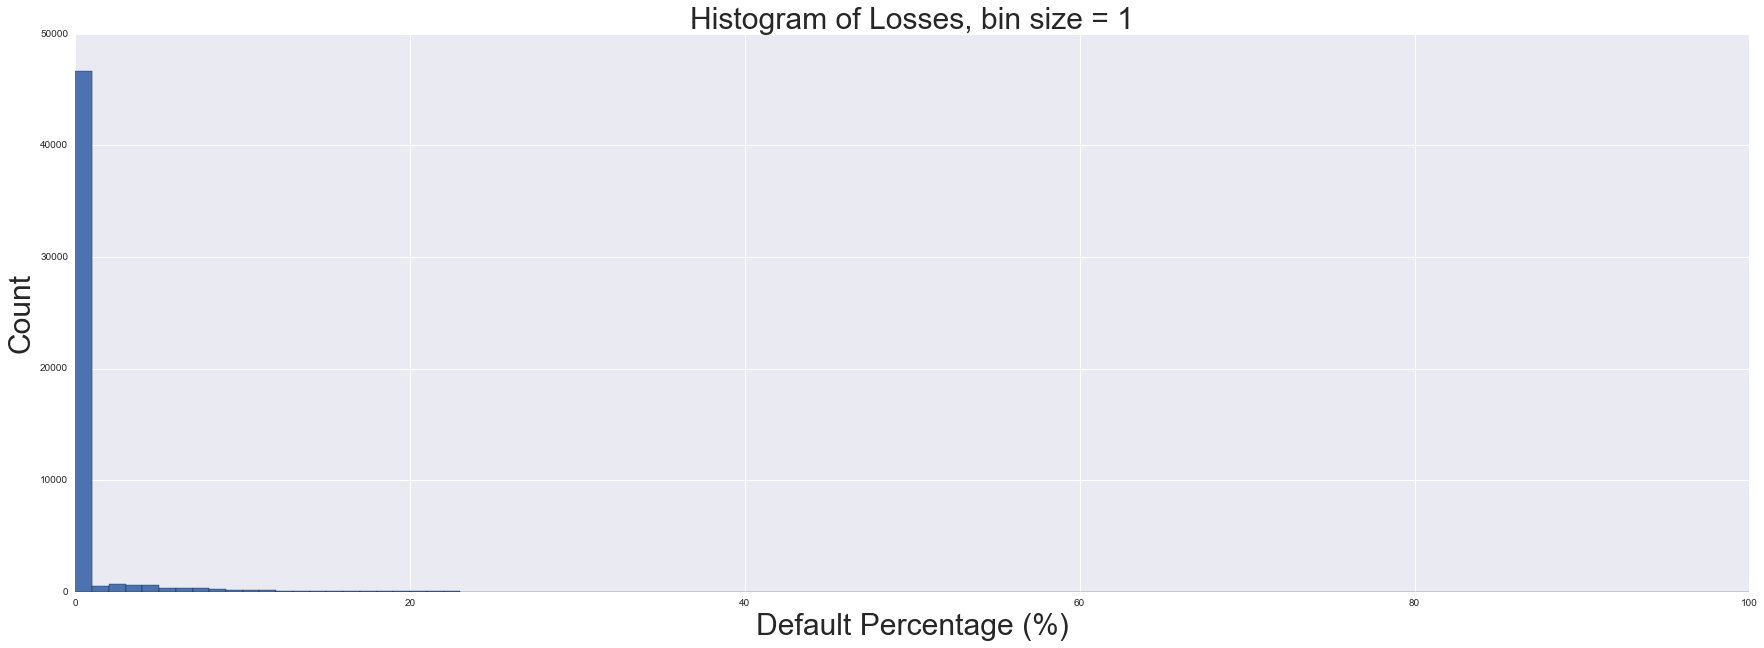

Amount of defaulted loans (loss > 0%): 5275


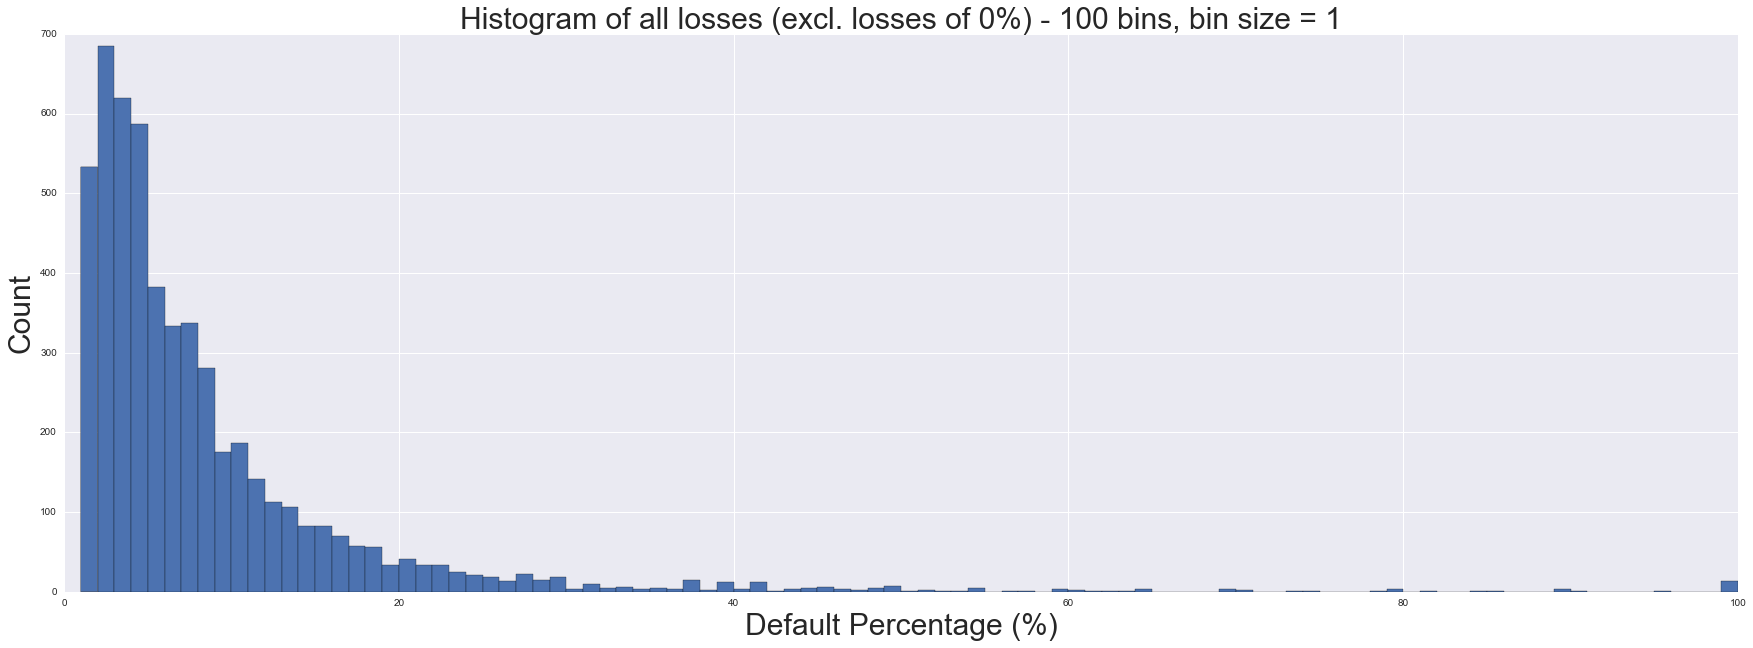

In [3]:
# 1st histogram:
fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(111)
ax.set_title('Histogram of Losses, bin size = 1', fontsize=30)
ax.set_xlabel('Default Percentage (%)', fontsize=30)
ax.set_ylabel('Count', fontsize=30)

plt.hist(data['loss'], bins=100)
plt.show()

# 2nd histogram:
data_Losses = data[data['loss'] != 0] # Keep only loans with losses > 0
print('Amount of defaulted loans (loss > 0%):', data_Losses.shape[0])

fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(111)
ax.set_title('Histogram of all losses (excl. losses of 0%) - 100 bins, bin size = 1', fontsize=30)
ax.set_xlabel('Default Percentage (%)', fontsize=30)
ax.set_ylabel('Count', fontsize=30)

plt.hist(data_Losses['loss'], bins=99)
plt.show()

## 1C. Clustering:
For a quick visual check of whether there are any correlated feature variables we split the (training) data into two parts, one with loss = 0 and one with loss > 0 and then run a clustering algorithm on it and display it. NB: an attempt at using the sns.clustermap() function led to error messages, in the interest of time I did not pursue this any further.

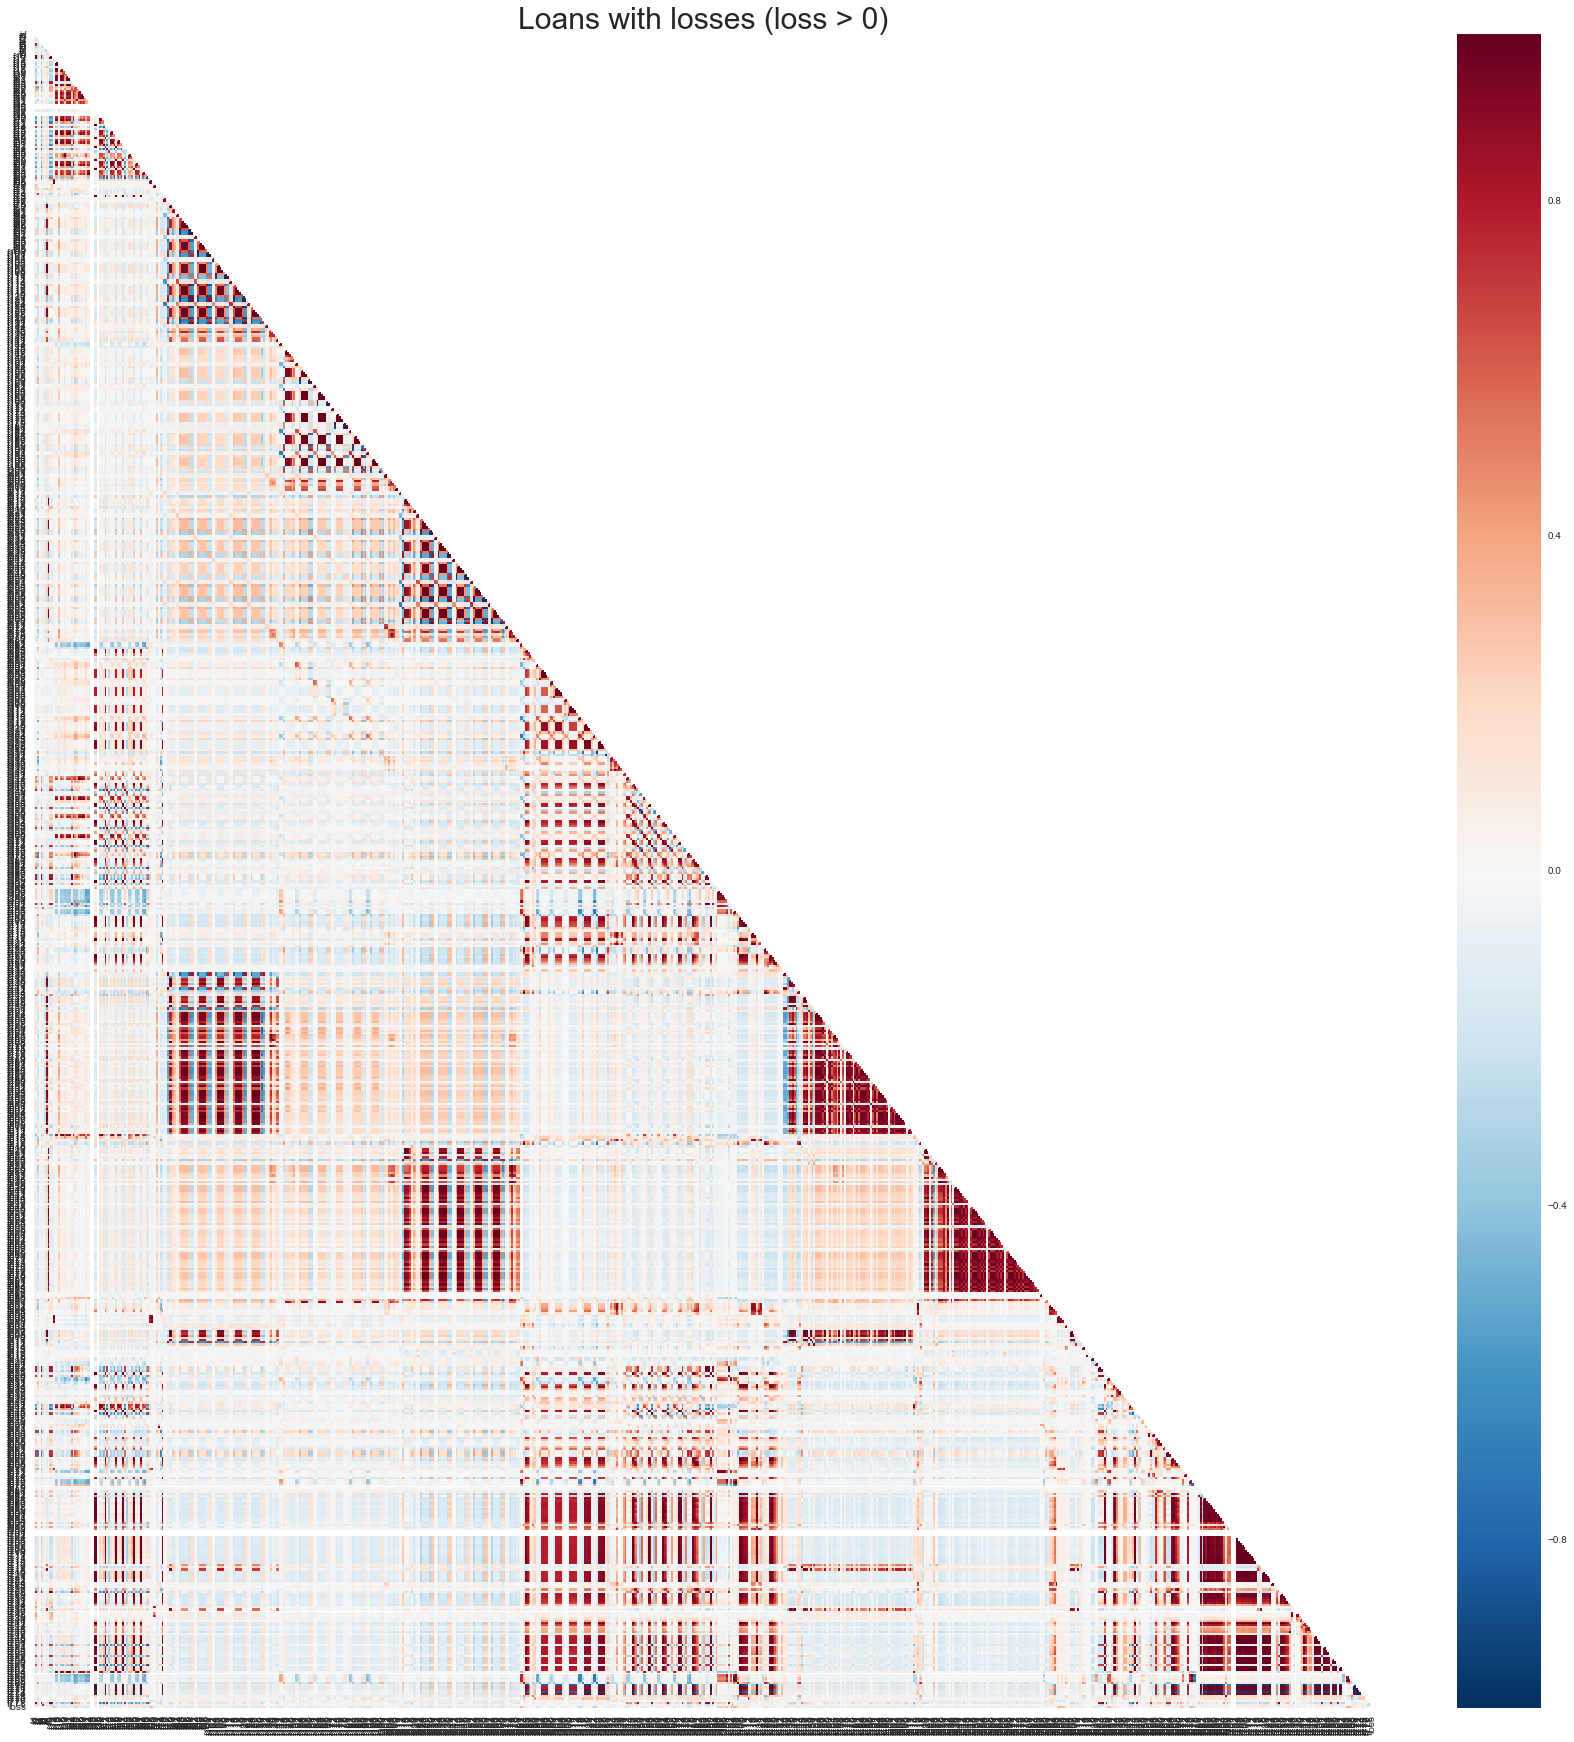

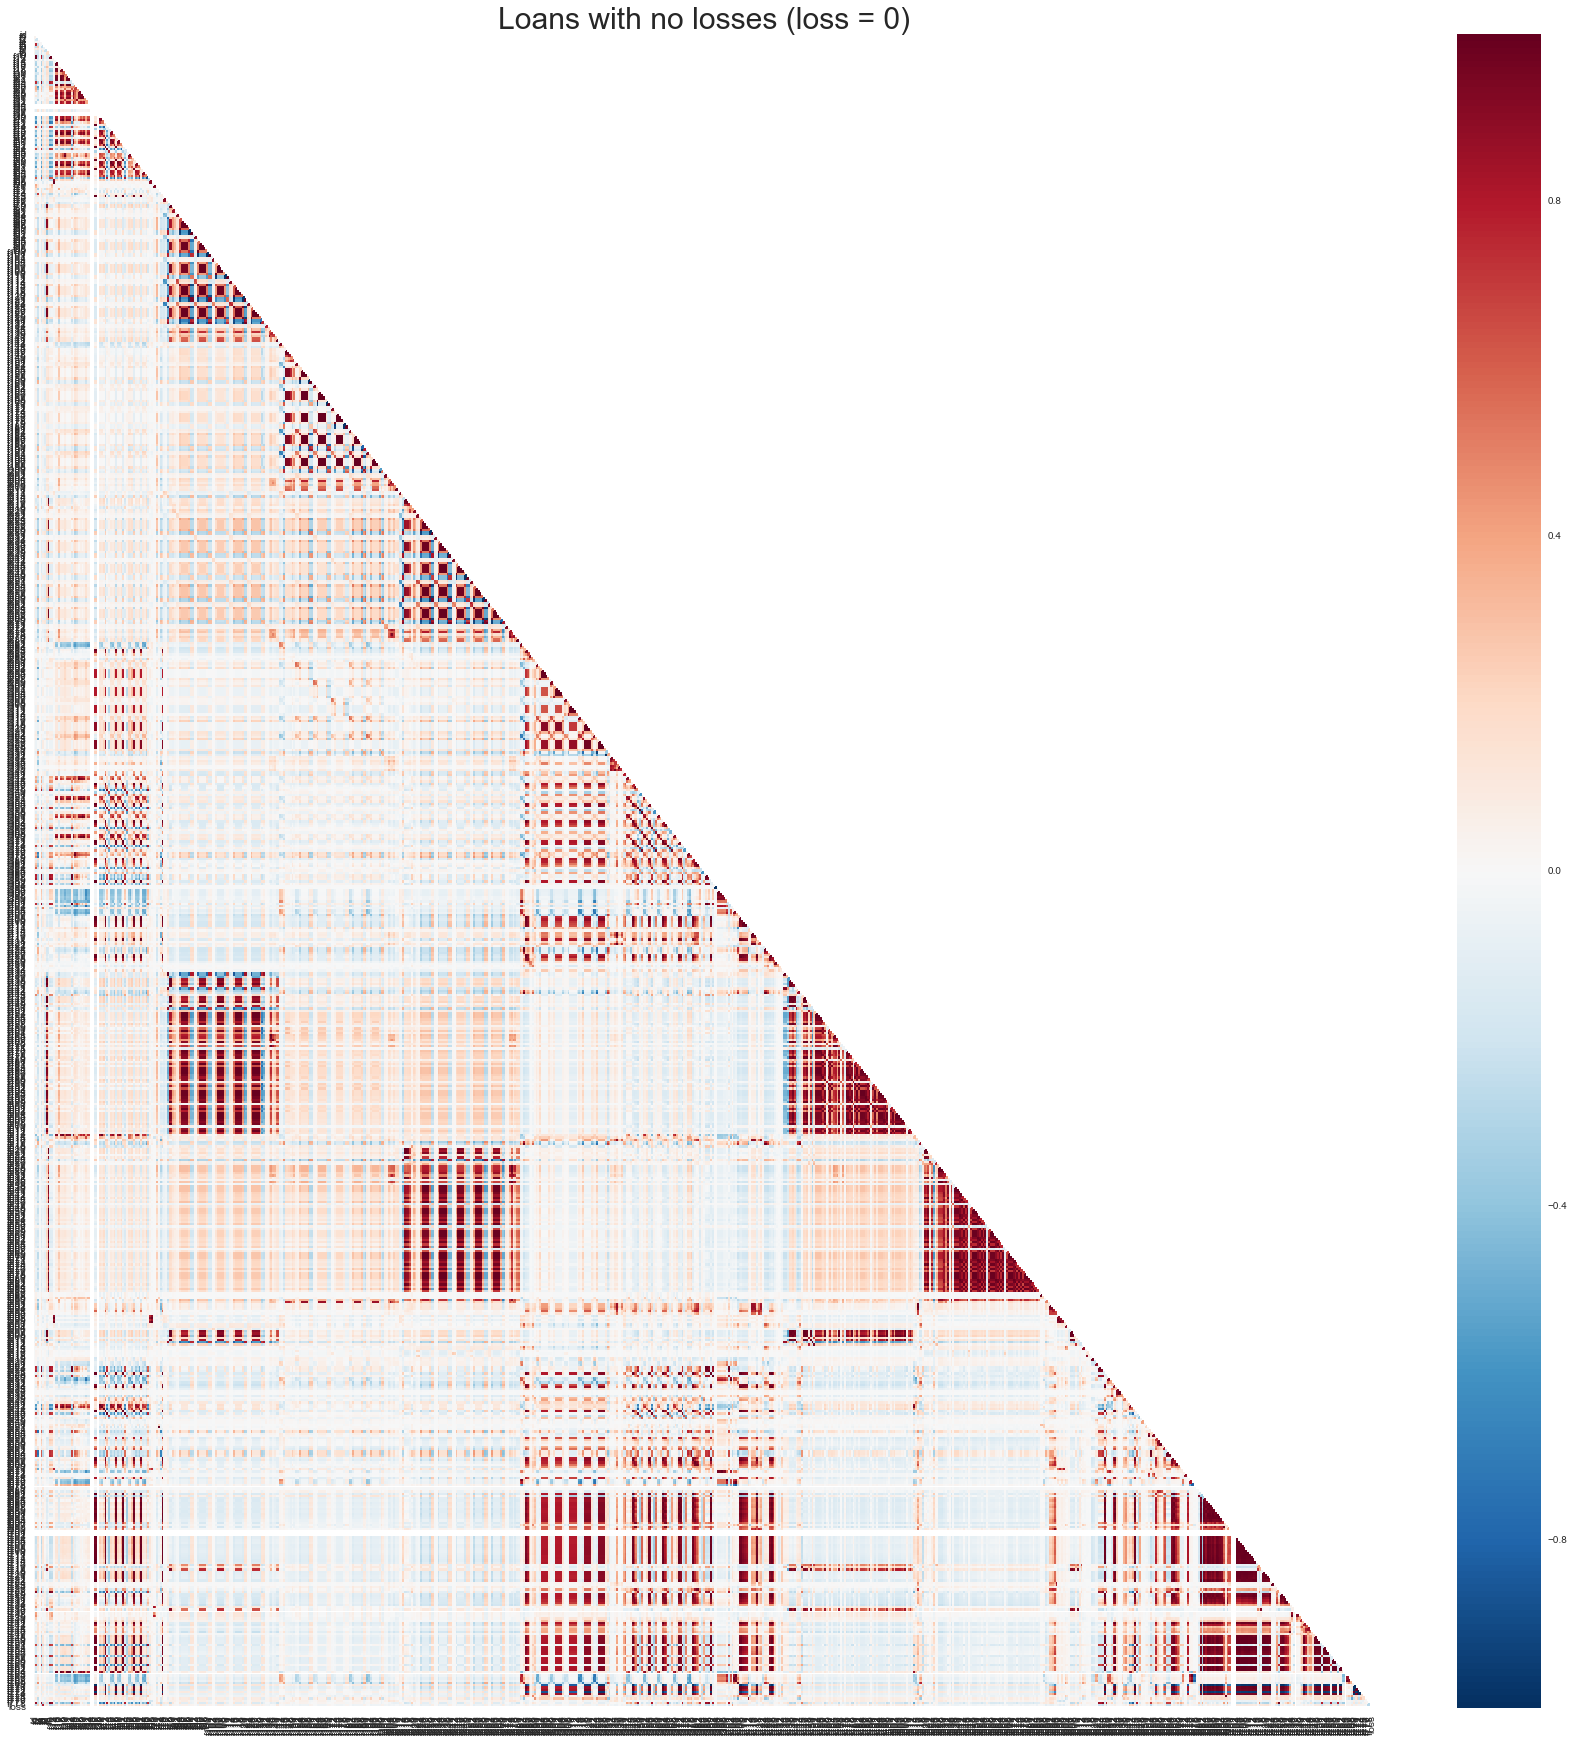

In [4]:
# sns.heatmap() - data_Losses:
fig = plt.figure(figsize=(30, 30))
mask = np.zeros_like(data_Losses.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    results_correlogram = sns.heatmap(data_Losses.corr(), mask=mask, vmin=-1, vmax=1)
ax = fig.add_subplot(111)
ax.set_title('Loans with losses (loss > 0)', fontsize=30)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

data_NoLosses = data[data['loss'] == 0] # Keep only loans with losses = 0

# sns.heatmap() - data_NoLosses:
fig = plt.figure(figsize=(30, 30))
mask = np.zeros_like(data_NoLosses.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    results_correlogram = sns.heatmap(data_NoLosses.corr(), mask=mask, vmin=-1, vmax=1)
ax = fig.add_subplot(111)
ax.set_title('Loans with no losses (loss = 0)', fontsize=30)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# sns.clustermap() - produces an error message:
#fig = plt.figure(figsize=(30, 30))
#results_correlogram_clustered = sns.clustermap(data_Losses.corr(), method='average', metric='euclidean', figsize=(30, 30))
#plt.setp(results_correlogram_clustered.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
#plt.show()

## 1D. Dimensionality reduction using PCA:
Principle component anaylsis (PCA) can be used in the exploratory data analysis, however it is not suitable for highly correlated variables, but useful for decorrelating, reducing and normalizing features. NB that PCA is not a feature selection algorithm since the target variable y is not treated separately. tSNE might also be worthwhile to evaluate at this stage, but in the interest of time I did not pursue this any further.

# 2. Feature Transformations:
Often, feature variables may be need to be transformed for several reasons: modeling techniques may have strict requirements (e.g. feature variables having a common scale), while in other cases a specific model may be difficult to implement due to certain characteristics of the data (e.g. outliers). Possible feature transformations are:

* Normalizing and scaling: Normalizing the data set using a specific feature variable, and then scale each feature between 0 and 1, resulting in each feature variable having a minimum value of 0 and a maximum value of 1.
* Log Transform of Data: Replacing the data with the log, square root, or inverse may help to remove any skewness present in the data.
* Box-Cox Transform of Data: G. E. P. Box and D. R. Cox proposed using maximum likelihood estimation to determine a transformation parameter, a procedure applied independently to each feature variable that contain values greater than zero

# 3. Feature Engineering:
Feature engineering is required to process the data in a way to optimize the performance of machine learning algorithms used on the data. Data often includes strongly correlated feature variables that impact the performance of a machine learning algorithm which is why feature engineering techniques include selecting a group of relevant features that can be fed in to a machine learning algorithm.

The "Elastic-Net" is a regression method that combines the L1 and L2 penalties of the LASSO and ridge regression methods, and is being used here to decrease the number of feature variables.

In [5]:
# Split into feature variables X and target variable y:
X = data.drop(['loss'], 1)
y = data['loss']

random_state = 123
cv = None

regr_ENet = ElasticNet()
regr_ENet_pred = regr_ENet.fit(X, y).predict(X)
regr_ENet_scores = cross_val_score(regr_ENet, X, y, cv=cv)
regr_ENet_RSS = ((y - regr_ENet_pred)**2).sum()
regr_ENet_MSE = np.mean((regr_ENet.predict(X) - y) **2)
print('Elastic Net - Accuracy: %0.3f (+/- %0.3f)' % (regr_ENet_scores.mean(), regr_ENet_scores.std() * 2))
print('Elastic Net - Residual Sum of Squares: %0.3f' % regr_ENet_RSS)
print('Elastic Net - Mean Squared Error: %0.3f' % regr_ENet_MSE)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/pyth

Elastic Net - Accuracy: -0.095 (+/- 0.149)
Elastic Net - Residual Sum of Squares: 862567.697
Elastic Net - Mean Squared Error: 16.607


# 4. Machine Learning:
A simple model to try here is multiple linear regression, however this assumes a linear relationship between the target variable and the feature variables, normal distribution of variables and homoscedasticity.
## 4A. Preparing feature-selected data for ML:
As we can see, the Elastic Net regression was able to decrease the amount of feature variables from 770 to 207:

In [6]:
results_FeatSel = pd.DataFrame(regr_ENet.coef_)

# Get rid of features with regr_coef = 0, as these are the features that have been filtered out:
results_var_names = pd.DataFrame(X.columns)
results = pd.concat([results_var_names, results_FeatSel], axis=1, join_axes=[results_var_names.index])
results.columns = ['feature_variable', 'regr_coef']
results.sort_values('regr_coef', axis=0, ascending=False, inplace=True)
results = results[results['regr_coef'] != 0]

# Selected feature variables to be fed into ML algorithm:
X2 = data[list(results['feature_variable'])]

print('Before algorithmic feature selection:', X.shape)
print('After algorithmic feature selection:', X2.shape)

Before algorithmic feature selection: (51940, 770)
After algorithmic feature selection: (51940, 207)


## 4B. Use feature-selected variables as an input to a ML algorithm:

In [7]:
# Train/test split on the feature selected variables:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.25, random_state=random_state)

lin_reg = LinearRegression()
y_pred_linreg = lin_reg.fit(X_train, y_train).predict(X_test)

r2_score_linreg = r2_score(y_test, y_pred_linreg)
RSS = ((y_test - lin_reg.predict(X_test)) **2).sum()
MSE = np.mean((lin_reg.predict(X_test) - y_test) **2)
print('Linear Regression - R^2 Score on test data: %0.3f' % r2_score_linreg)
print('Linear Regression - Residual Sum of Squares: %0.3f' % RSS)
print('Linear Regression - Mean Squared Error: %0.3f' % MSE)

# Make & evaluate predictions:
predictions = [round(value) for value in y_pred_linreg]
accuracy = accuracy_score(y_test, predictions)
print("Linear Regression - Accuracy: %.2f%%" % (accuracy * 100.0))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Linear Regression - R^2 Score on test data: -0.000
Linear Regression - Residual Sum of Squares: 218701.834
Linear Regression - Mean Squared Error: 16.843
Linear Regression - Accuracy: 1.40%


## 4C. Use the model on the test data:

In [10]:
# Get test data:
data_test = data_test.dropna(axis=0, how='any')

# Selected feature variables to be fed into the ML algorithm:
X_data_test = data_test[list(results['feature_variable'])]

# Using the ML algorithm to predict target variable y of the test data:
y_data_test = lin_reg.predict(X_data_test)

# Assemble and generate submission file:
y_data_test_df = pd.DataFrame(y_data_test)
y_data_test_df.columns = ['loss']
y_data_test_df = y_data_test_df.reset_index()

SGL_Submission = pd.concat([X_data_test['id'], y_data_test_df], axis=1)
SGL_Submission.drop('index', 1, inplace=True)
SGL_Submission.to_csv('SGL_Submission.csv', index=False)

# 5. Discussion & outlook:
Given the amount of time, some aspects particularly regarding data processing and cleaning were not followed up adequately, for example detecting and dealing with outliers, and more thoroughly assessing the data in order find any other issues that might impact the performance of any subsequent ML algorithms.

Regarding the predictions of the linear regression model, the fact the the R^2 score is 0 indicates that the model appears to be a "constant" model that always predicts the expected value of y, disregarding the input features.

The accuracy score of 1.4% shows that the model is very poor, and ultimately unable to make predictions. While a regression is not the most sophisticated model available, its performance should be better than that - I suspect that the reason for the poor perfomance is to be found in the train test split, as there are too many loans with loss = 0.

A solution for this would be to experiment with different train/test splits and making sure that there is an adequate representation of loss values > 0, relative to the samples with loss values = 0 in both the train and test split.

Another issue is the removal of the 'NA' values, since this decreases the number of samples/rows in both the training and the test data, in the latter case down to 95'256 rows, while the Kaggle competition expects the original amount of 210'944 rows in the submission file, consistent with the amount of rows in the test data. Here, perhaps a substitution of 'NA' values might be a better approach rathen than deleting them, by calculating the mean or the median for a given feature and substitute the 'NA' values with that.

Once these issues are resolved, more advanced ML algorithms can be tested for their suitability and performance for this problem - from random forests all the way to neural nets.